In [1]:
# Data handling libraries
import pandas as pd
import numpy as np

# Web Scrapping and data obtension
import requests, zipfile, io
from bs4 import BeautifulSoup
import html5lib

# ML libraries
import gplearn as gp
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.preprocessing import MinMaxScaler

# DataViz Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data model save
import pickle

In [2]:
# Plot format
plt.rcParams.update({'mathtext.default':'regular'}) # Latex in text
sns.set(context='notebook', font='Times New Roman', font_scale=1, style='ticks') # Formal style
%matplotlib notebook

In [3]:
### Download databases with some web scrapping by using the data from the official git repository
url = "https://github.com/CSSEGISandData/COVID-19/archive/master.zip"
html = requests.get(url,stream = True)

# Data is in a zip file, therefore we have to extract the files
z = zipfile.ZipFile(io.BytesIO(html.content))
z.extractall('./Files/info')

In [71]:
# Obtain the data8 Confirmed cases in the world in a time series format. 
small_path = "./Files/info/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series"

cases = {"confirmed_cases" : pd.read_csv(f'{small_path}/time_series_19-covid-Confirmed.csv'),
"death_cases" : pd.read_csv(f'{small_path}/time_series_19-covid-Deaths.csv'),
"recovered_cases" : pd.read_csv(f'{small_path}/time_series_19-covid-Recovered.csv')}

cases['confirmed_cases'].head()
cases['confirmed_cases'][cases['confirmed_cases']['Country/Region']=='US'].head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
100,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,0,0,0,0,0,267,366,442,568,572
101,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,0,0,0,0,0,173,220,328,421,525
102,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,0,0,0,0,0,144,177,221,282,340
103,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,0,0,0,0,0,92,95,108,123,138
104,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,45,45,45,45,45,46,46,46,46,46


In [5]:
#Create a dictionary of the cases in time, for mainland china and for not mainland china
cases_general = {}
cases_words = ['confirmed','recovered','death']

# Define a variable for mainland and outside china:
location = ['mainland','outside']

for word in cases_words:
    # Empty dictionary
    cases_in_time = {}
    
    # Columns
    non_usable = 4

    # Confirmed cases only in china
    mainland_china = cases[f'{word}_cases'][cases[f'{word}_cases']['Country/Region'] == 'China']
    cases_in_time[f'{word}_mainland_china'] = np.array(mainland_china.sum()[non_usable:], dtype=float)

    #Confirmed cases in other places but china
    outside_china = cases[f'{word}_cases'][cases[f'{word}_cases']['Country/Region'] != 'China']
    cases_in_time[f'{word}_outside_china'] = np.array(outside_china.sum()[non_usable-2:], dtype=float)
    
    # Save in the dictionary each of the cases
    cases_general[word] = cases_in_time
data_dataframe = pd.concat([pd.DataFrame(cases_general[key] ) for key in cases_general.keys()], axis=1)

# Include the actual cases
for place in location:
    data_dataframe[f'actual_cases_{place}_china'] =  data_dataframe[f'confirmed_{place}_china']-(data_dataframe[f'death_{place}_china']+data_dataframe[f'recovered_{place}_china'])

# Include the actual cases into the cases_word
cases_words.append('actual_cases')

data_dataframe.head()

,confirmed_mainland_china,confirmed_outside_china,recovered_mainland_china,recovered_outside_china,death_mainland_china,death_outside_china,actual_cases_mainland_china,actual_cases_outside_china
0,548.0,7.0,28.0,0.0,17.0,0.0,503.0,7.0
1,643.0,10.0,30.0,0.0,18.0,0.0,595.0,10.0
2,920.0,21.0,36.0,0.0,26.0,0.0,858.0,21.0
3,1406.0,28.0,39.0,0.0,42.0,0.0,1325.0,28.0
4,2075.0,43.0,49.0,3.0,56.0,0.0,1970.0,40.0


In [6]:
# Change the scale (normalize by making the max value  = 1 and the min value = 0 ) 
# of the data with MinMaxScaler function
scaler = MinMaxScaler()
scaler.fit(data_dataframe)

# Normalization of the dataframe
norm_dataframe = pd.DataFrame(scaler.transform(data_dataframe))
norm_dataframe.columns = [f'norm_{element}' for element in data_dataframe.columns]
norm_dataframe.head()

,norm_confirmed_mainland_china,norm_confirmed_outside_china,norm_recovered_mainland_china,norm_recovered_outside_china,norm_death_mainland_china,norm_death_outside_china,norm_actual_cases_mainland_china,norm_actual_cases_outside_china
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.001181,0.000040,0.000030,0.000000,0.000315,0.0,0.001597,0.000046
2,0.004625,0.000186,0.000122,0.000000,0.002834,0.0,0.006163,0.000214
3,0.010668,0.000280,0.000168,0.000000,0.007872,0.0,0.014270,0.000320
4,0.018986,0.000479,0.000320,0.000431,0.012280,0.0,0.025467,0.000504


In [7]:
# Determine a numerical value for the dates

# We will use the dates in the dataset, to easily identify this, it is possible to use a common
# trait such as '/20'. 
timelapse = [pd.to_datetime(elem) for elem in cases['confirmed_cases'].columns if '/20' in elem]

time_numerical_value = [int(str(timelapse[i] - timelapse[0]).split(' ')[0]) for i in range(len(timelapse))]

# Time from the day Jan/22/20
time_information = pd.DataFrame([timelapse,time_numerical_value]).T
time_information.columns = ['date','numerical_value']

# Save the last date for the model:
last_date_for_model = str(list(time_information['date'])[-1]).split(' ')[0]

time_information.tail()

,date,numerical_value
48,2020-03-10,48
49,2020-03-11,49
50,2020-03-12,50
51,2020-03-13,51
52,2020-03-14,52


In [8]:
days = list(time_information.tail(1).numerical_value)[0]
startdate = time_information.date[0]
enddate = ['-'.join(str(pd.to_datetime(startdate) + pd.DateOffset(days=i)).split(' ')[0].split('-')[1:])
           for i in range(days+2)]

day_freq = 5


day_pos, day_text = [day_freq*i for i in range(len(enddate)//day_freq+1)],[enddate[day_freq*i] for i in range(len(enddate)//day_freq+1)]


In [9]:
# Create a dataframe with all the information

# All dataframes merged
cases_dataframe = pd.concat([time_information,data_dataframe,norm_dataframe],axis=1)

# Obtain the percentages

# death and recovered percentages` in different locations
for place in location:
    cases_dataframe[f'death_percentage_{place}_china'] = 100*cases_dataframe[f'death_{place}_china']/cases_dataframe[f'confirmed_{place}_china']
    cases_dataframe[f'recovered_percentage_{place}_china'] = 100*cases_dataframe[f'recovered_{place}_china']/cases_dataframe[f'confirmed_{place}_china']
    
# Show all the information
cases_dataframe.head()

,date,numerical_value,confirmed_mainland_china,confirmed_outside_china,recovered_mainland_china,recovered_outside_china,death_mainland_china,death_outside_china,actual_cases_mainland_china,actual_cases_outside_china,...,norm_recovered_mainland_china,norm_recovered_outside_china,norm_death_mainland_china,norm_death_outside_china,norm_actual_cases_mainland_china,norm_actual_cases_outside_china,death_percentage_mainland_china,recovered_percentage_mainland_china,death_percentage_outside_china,recovered_percentage_outside_china
0,2020-01-22,0,548.0,7.0,28.0,0.0,17.0,0.0,503.0,7.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.102190,5.109489,0.0,0.000000
1,2020-01-23,1,643.0,10.0,30.0,0.0,18.0,0.0,595.0,10.0,...,0.000030,0.000000,0.000315,0.0,0.001597,0.000046,2.799378,4.665630,0.0,0.000000
2,2020-01-24,2,920.0,21.0,36.0,0.0,26.0,0.0,858.0,21.0,...,0.000122,0.000000,0.002834,0.0,0.006163,0.000214,2.826087,3.913043,0.0,0.000000
3,2020-01-25,3,1406.0,28.0,39.0,0.0,42.0,0.0,1325.0,28.0,...,0.000168,0.000000,0.007872,0.0,0.014270,0.000320,2.987198,2.773826,0.0,0.000000
4,2020-01-26,4,2075.0,43.0,49.0,3.0,56.0,0.0,1970.0,40.0,...,0.000320,0.000431,0.012280,0.0,0.025467,0.000504,2.698795,2.361446,0.0,6.976744


<IPython.core.display.Javascript object>


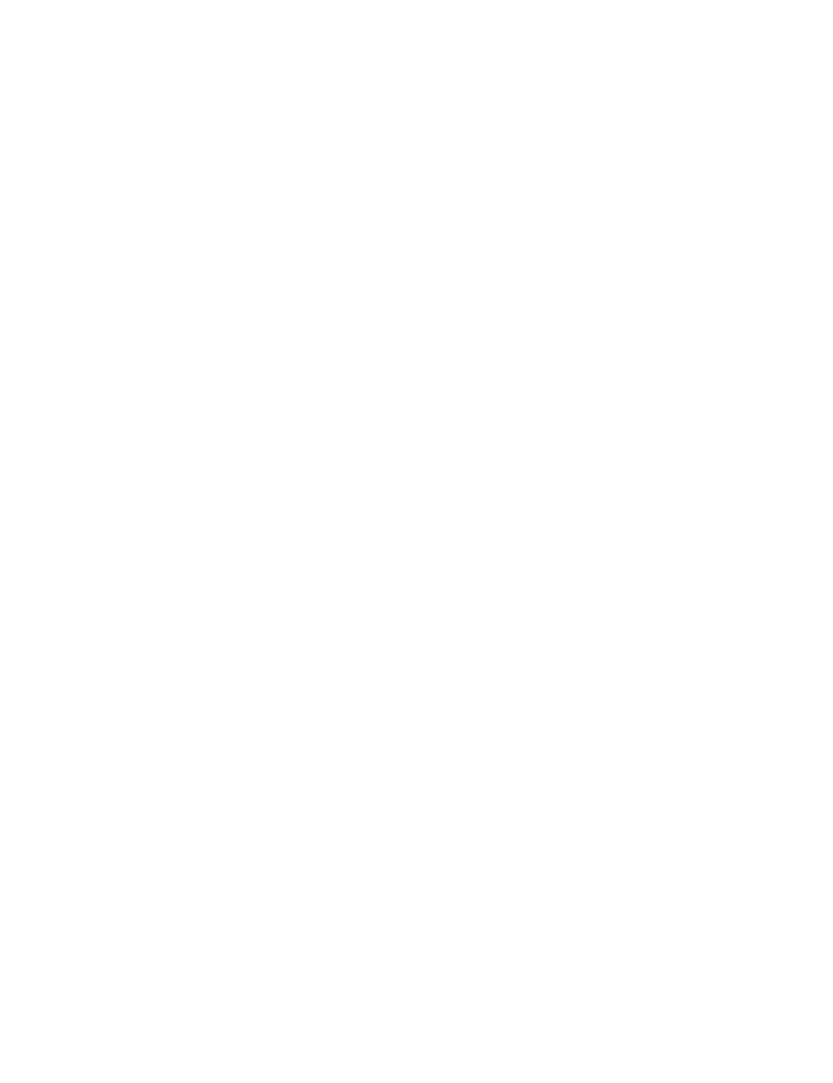

In [10]:
# Plots of the normalized traits and their importances

fig = plt.figure(figsize=(10,13))

# Some parameters for the plotting format
spacing = np.arange(0,int(max(cases_dataframe['numerical_value']))+2, step=3)
transparent = .4


color_plots = '#F67280', '#355C7D'
color_norm_plots = 'magenta','cyan'
# Plot the world cases. 
for pos,word in enumerate(cases_words):
    # All the cases (untransformed data)
    plt.subplot(len(cases_words),2,2*pos+1)
    
    # Scatter plot for place
    for i,place in enumerate(location): 
        plt.scatter(cases_dataframe['numerical_value'], cases_dataframe[f'{word}_{place}_china'],
                    color = color_plots[i], label = f'{place.capitalize()} China', alpha = transparent
                   )
    
    # Writen parameters of the plot
    plt.title(f'{word.capitalize().replace("_", " ")} Cases')
    plt.ylabel(f'Values of the {word.replace("_", " ")} cases')
    plt.xlabel('Date (year 2020)')
    
    # Grid and legend
    plt.xticks(day_pos,day_text, rotation = -60)
    plt.grid()
    plt.legend()
    
    # Normalized cases
    plt.subplot(len(cases_words),2,2*pos+2)
    
    #Scatter plot for normalized places
    for i,place in enumerate(location): 
        plt.scatter(cases_dataframe['numerical_value'], cases_dataframe[f'norm_{word}_{place}_china'],
                     color = color_norm_plots[i], label = f'{place.capitalize()} China', alpha = transparent
                    )
    
    # Written parameters of the plot
    plt.title(f'Normalized {word.capitalize().replace("_", " ")} Cases')
    plt.ylabel(f'Normalized values of the \n {word.replace("_", " ")} cases')
    plt.xlabel('Date (year 2020)')
    
    # Grid and legends
    plt.yticks(np.arange(0,1.1,step=.1))
    plt.xticks(day_pos,day_text, rotation = -60)
    plt.grid()
    plt.legend()

# Automatically modify the position of the plots
plt.tight_layout()

<IPython.core.display.Javascript object>


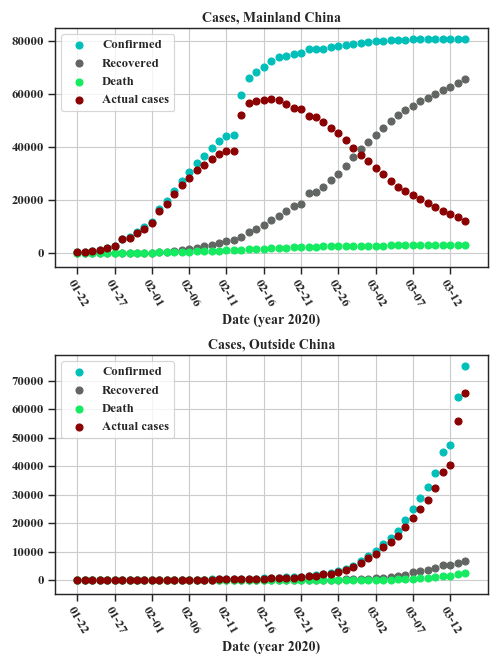

In [11]:
# Select colors for the plots
colors = ['#00bfb9', '#15eb60','#626663','#8B0000']

# Plot the data for the number of cases
plt.figure(figsize=(6,8))
for position,place in enumerate(location):
    
    # Generate two subplots, for the different places
    plt.subplot(2,1,position+1)
    for i,word in enumerate(cases_words):
        
        # Scatter for every case
        plt.scatter(cases_dataframe['numerical_value'], cases_dataframe[f'{word}_{place}_china'],
                    color = colors[i], label = word.capitalize().replace('_',' '))
        
    plt.title(f'Cases, {place.capitalize()} China')
    plt.xticks(day_pos,day_text,rotation=-60)
    plt.xlabel('Date (year 2020)')
    plt.grid()
    plt.legend()
        
plt.tight_layout()

In [12]:
# Non dependeant variable for regressions (numerical value of the date).
X0_DATA = np.array(cases_dataframe['numerical_value'],dtype=float).reshape(-1,1)

In [13]:
# Use the Symbolic Regressor for normalized data

# Define an exponential operator to create a symbolic function
def _protected_exponent(x1):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x1) < 100, np.exp(x1), 0.)
    
# Create a compatible function with the list for the function_set
exponential = make_function(function=_protected_exponent, name='exp', arity=1)

# Function List
f_list = ['add','sub','mul', exponential]
# Create an empty dictionary which will contain two Symbolic Regressors, depending on the location
estimator_symbolic_reg = {}
for place in location:
    # Create a Symbolic Regressor object (estimator genetic predictor)
    estimator_symbolic_reg[place] =  [SymbolicRegressor(population_size = 10000,
                                       generations = 15,
                                       stopping_criteria = 0.001,
                                       function_set = f_list,
                                       p_crossover = 0.70,
                                       p_subtree_mutation = 0.20,
                                       max_samples = 0.97,
                                       verbose = 0,
                                       parsimony_coefficient = 0.001) for i in range(len(cases_words))]

In [14]:
# Fit the data to each of the Symbolic Regressor Objects
for i in range(len(cases_words)):
    for place in location:
        estimator_symbolic_reg[place][i].fit(X0_DATA , cases_dataframe[f'norm_{cases_words[i]}_{place}_china'])
    print('')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    27.65     4.76166e+128        7         0.112927         0.175677      2.24m
   1    14.53      2.17231e+72       42        0.0919783        0.0501719      1.58m
   2    19.00       3.9727e+72       56        0.0628828        0.0325407      1.60m
   3    30.56      3.44578e+65       49        0.0436687        0.0310716      1.65m
   4    29.62      2.82696e+56       49        0.0407997        0.0694537      1.51m
   5    26.12      5.55755e+78       72        0.0334285        0.0104269      1.28m
   6    37.74      6.36792e+43       78        0.0286359        0.0468383      1.27m
   7    38.47      1.19774e+39       77        0.0310639         0.120618      1.16m
   8    34.67      2.35767e+39       58        0.0304759        0.0157095  

   5    19.78      2.06985e+81       35        0.0163402         0.152966      1.16m
   6    20.16      3.21796e+84       25        0.0119566        0.0100944      1.13m
   7    20.43     2.10633e+128       25        0.0116646        0.0175407      1.08m
   8    23.07      7.55322e+80       54        0.0113361       0.00528417     58.72s
   9    27.78      2.49586e+80       25        0.0107794        0.0401141     53.67s
  10    27.25      7.16386e+60       25        0.0094724        0.0734417     43.55s
  11    24.46      1.59975e+60       31       0.00978222        0.0424961     34.50s
  12    23.05        5.212e+61       25       0.00990935        0.0622994     21.10s
  13    23.07      1.78315e+67       25       0.00792651        0.0324691     10.78s
  14    23.98      3.58466e+86       25       0.00692453        0.0580196      0.00s

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ 

In [15]:
# Show the results
for i in range(len(cases_words)):
    for place in location:
        sym_reg = estimator_symbolic_reg[place][i]
        # Show the program
        print(f'{cases_words[i]} {place} China: {sym_reg._program}')
        
        # Delete past generations
        delattr(sym_reg,'_programs')
        
        # Save the model
        with open(f'./Results/Covid_19_symbolic_regression_model_{cases_words[i]}_{place}_{last_date_for_model}.pkl','wb') as f:
            pickle.dump(sym_reg,f)
    print('')

confirmed mainland China: exp(mul(mul(exp(mul(-0.324, X0)), exp(add(0.060, -0.327))), add(-0.604, add(sub(sub(X0, 0.757), exp(exp(X0))), mul(sub(0.931, X0), sub(X0, 0.304))))))
confirmed outside China: exp(sub(add(-0.363, sub(X0, X0)), add(sub(exp(add(0.315, 0.794)), add(sub(X0, X0), mul(X0, 0.089))), add(sub(exp(add(0.315, 0.794)), add(mul(add(-0.476, -0.947), 0.089), mul(X0, 0.089))), exp(exp(sub(X0, X0)))))))

recovered mainland China: exp(mul(exp(mul(-0.061, add(add(X0, -0.316), add(mul(0.009, X0), X0)))), sub(add(mul(0.009, X0), sub(-0.230, X0)), exp(exp(exp(-0.128))))))
recovered outside China: exp(sub(sub(exp(X0), add(add(exp(X0), exp(sub(exp(0.935), sub(sub(sub(exp(X0), add(exp(X0), mul(X0, X0))), exp(exp(X0))), exp(-0.501))))), mul(X0, X0))), 0.561))

death mainland China: mul(exp(add(exp(-0.144), mul(X0, -0.033))), mul(sub(add(-0.859, X0), exp(0.981)), mul(mul(-0.716, X0), mul(0.004, -0.296))))
death outside China: mul(mul(mul(exp(mul(X0, 0.088)), mul(0.123, 0.674)), mul(mul(

In [16]:
def polyfits_to_data(x,y,order,data):
    # Values of the polynomial regression:
    value = np.polyfit(x,y,order)
    
    # Numpy array of the data
    data = np.array(data)
    # Polynomial values
    ans = sum([value[v]*data**(order-v) for v in range(order)])
    
    return ans

In [36]:
# Values for predicitons
x_data = X0_DATA.flatten() # Discrete values
x_values = np.linspace(0,days+7,1000) # Continuous values

# Predictions for polynomial regressions
order = [5,5,5,5] # Order of the polynomials
poly_regressions = {}
poly_regressions_discrete = {}
poly_column_names = []

# Predictions for the symbolic regressions
symb_regressions = {}
symb_regressions_discrete = {}
symb_column_names=[]

for i in range(len(cases_words)):
    for place in location:
        # Polynomial Regression predictions 
        txt_poly = f"{cases_words[i]}_{place}_poly_reg"
        poly_pred = polyfits_to_data(x_data,
                              cases_dataframe[f'{cases_words[i]}_{place}_china'], 
                              order[i], 
                              x_values )
        poly_discrete_pred = polyfits_to_data(x_data,
                              cases_dataframe[f'{cases_words[i]}_{place}_china'], 
                              order[i], 
                              x_data )
        poly_regressions[txt_poly] = poly_pred
        poly_regressions_discrete[txt_poly] = poly_discrete_pred
        poly_column_names.append(txt_poly)
        
        
        # Symbolic Regression predictions
        txt_symb = f"{cases_words[i]}_{place}_symb_reg"
        symb_regressions[txt_symb] = estimator_symbolic_reg[place][i].predict(x_values.reshape(-1,1))
        symb_regressions_discrete[txt_symb] = estimator_symbolic_reg[place][i].predict(X0_DATA)
        symb_column_names.append(txt_symb)
        
# Obtain a DF with all the predictions of the polynomial regression
poly_reg = pd.DataFrame(poly_regressions)
poly_reg.columns = poly_column_names

# Obtian a DF with all the discrete values predicted from the polynomial regression
values_poly_reg = pd.DataFrame(poly_regressions_discrete)
values_poly_reg.columns = poly_column_names
        
# Obtain a DF with all the predictions of the symbolic regression
symb_reg = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(symb_regressions)))
symb_reg.columns = symb_column_names

# Obtain a DF with all the discrete values predicted from the symbolic regression
values_symb_reg = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(symb_regressions_discrete)))
values_symb_reg.columns = symb_column_names

In [37]:
# Determine the absolute error on each value
abs_error_poly = pd.DataFrame(abs(np.array(values_poly_reg)-np.array(data_dataframe)))
abs_error_poly.columns = poly_column_names


abs_error_symb = pd.DataFrame(abs(np.array(values_symb_reg)-np.array(data_dataframe)))
abs_error_symb.columns = symb_column_names

# Proceed to obtain a value for the mean absolute error
mean_abs_error_symb , mean_abs_error_poly = abs_error_symb.mean(), abs_error_poly.mean()

In [38]:
# Speed and Acceleration (for the data) # Should reseble

# Data
speed_data_values = data_dataframe.apply(np.gradient)
accel_data_values = speed_data_values.apply(np.gradient)

# Symbolic Regression
speed_symb_reg_values = values_symb_reg.apply(np.gradient)
accel_symb_reg_values = speed_symb_reg_values.apply(np.gradient)

# Polynomial Regression
speed_poly_reg_values = values_poly_reg.apply(np.gradient)
accel_poly_reg_values = speed_poly_reg_values.apply(np.gradient)

In [39]:
# Speed and Acceleration (for the equations)

# Symbolic Regression
speed_symb_reg = symb_reg.apply(np.gradient)
accel_symb_reg = speed_symb_reg.apply(np.gradient)

# Polynomial Regression
speed_poly_reg = poly_reg.apply(np.gradient)
accel_poly_reg = speed_poly_reg.apply(np.gradient)

<IPython.core.display.Javascript object>


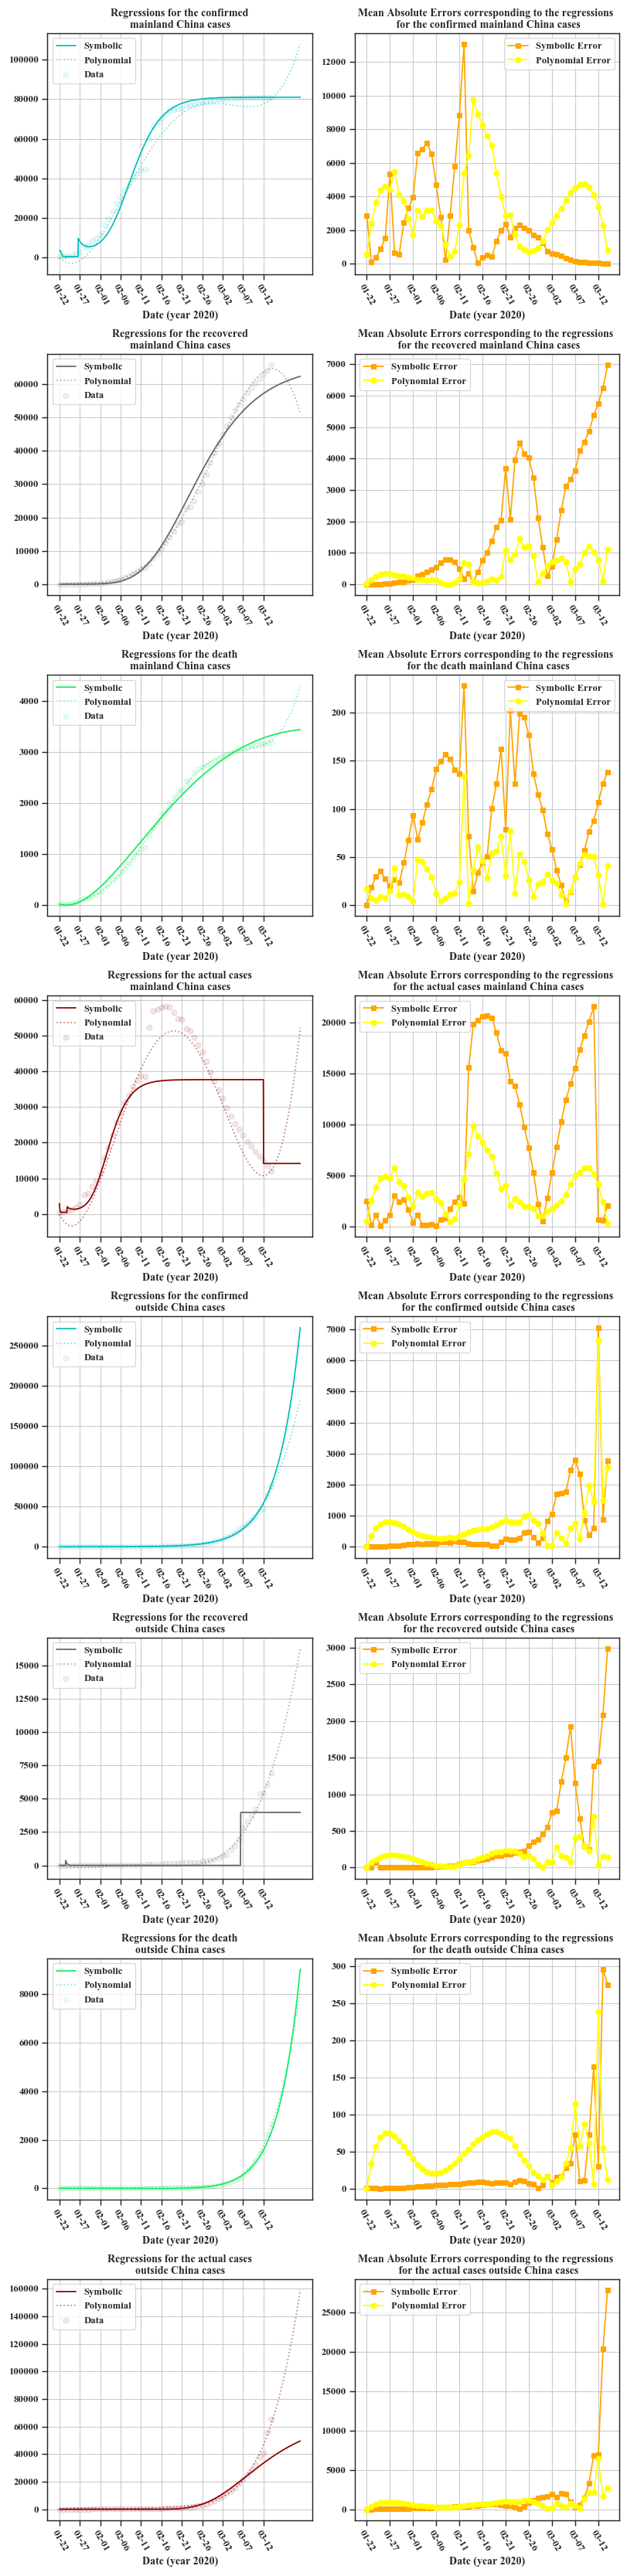

In [55]:
# Each data with the corresponding regression and error
plt.figure(figsize=(10,40))

for i in range(len(cases_words)):
    for place in location:
        
        # Conditions for plots
        if place == location[0]: a = 0
        else: a = 8
        
        # REGRESSIONS
        plt.subplot(8,2,2*i+1+a)
        # Data
        plt.scatter(x_data, cases_dataframe[f'{cases_words[i]}_{place}_china'], 
                    color = colors[i], alpha=.1, label = 'Data')
        # Symbolic regression
        plt.plot(x_values, symb_reg[f"{cases_words[i]}_{place}_symb_reg"], 
                 color = colors[i], alpha = 1, linestyle = '-', label = 'Symbolic')
        # Polynomial regression
        plt.plot(x_values, poly_reg[f"{cases_words[i]}_{place}_poly_reg"], 
                 color = colors[i], alpha = .5, linestyle = ':', label = 'Polynomial')
        
        plt.title(f'Regressions for the {cases_words[i].replace("_"," ")}\n{place} China cases')
        plt.xticks(day_pos,day_text,rotation=-60)
        plt.xlabel('Date (year 2020)')
        plt.legend()
        plt.grid()
        
        
        # ERRORS
        plt.subplot(8,2,2*i+2+a)
        # Symbolic regression
        plt.plot(x_data,abs_error_symb[f"{cases_words[i]}_{place}_symb_reg"],
                 color = 'Orange', marker = 's', label = 'Symbolic Error')
        
        # Polynomial regression
        plt.plot(x_data,abs_error_poly[f"{cases_words[i]}_{place}_poly_reg"],
                 color = 'Yellow', marker = 'o', label = 'Polynomial Error')
        plt.title(f'Mean Absolute Errors corresponding to the regressions \n for the {cases_words[i].replace("_"," ")} {place} China cases')
        plt.xticks(day_pos,day_text,rotation=-60)
        plt.xlabel('Date (year 2020)')
        plt.legend()
        plt.grid()

plt.tight_layout()

<IPython.core.display.Javascript object>


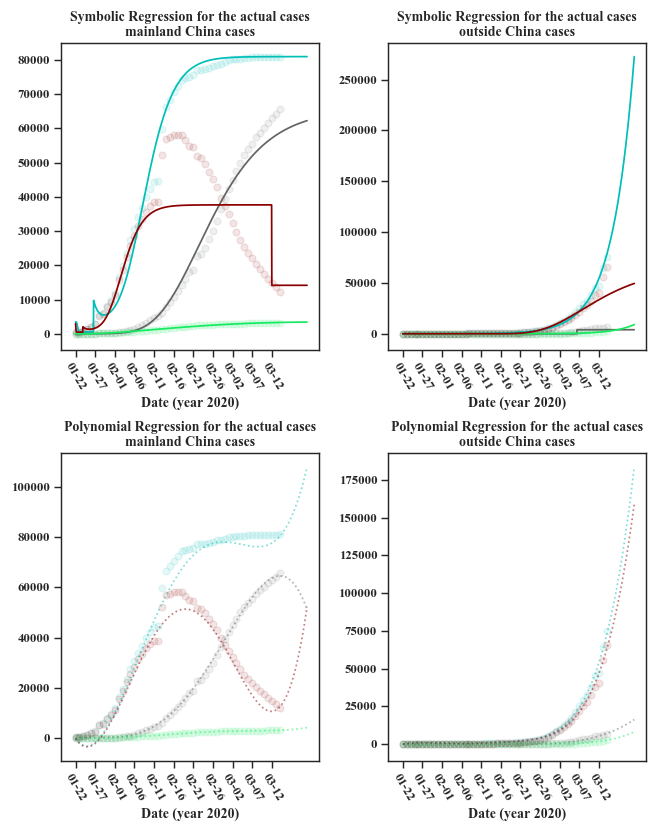

/home/dhdzmota/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/dhdzmota/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [69]:
# Graph with all the results plotted with the symbolic regression

# Each data with the corresponding regression and error
plt.figure(figsize=(8,10))

for i in range(len(cases_words)):
    for place in location:
        
        # Conditions for plots
        if place == location[0]: a = 0
        else: a = 1
        
        # REGRESSIONS
        plt.subplot(2,2,1+a)
        # Data
        plt.scatter(x_data, cases_dataframe[f'{cases_words[i]}_{place}_china'], 
                    color = colors[i], alpha=.1, label = 'Data')
        # Symbolic regression
        plt.plot(x_values, symb_reg[f"{cases_words[i]}_{place}_symb_reg"], 
                 color = colors[i], alpha = 1, linestyle = '-', label = 'Symbolic')
        
        plt.title(f'Symbolic Regression for the {cases_words[i].replace("_"," ")}\n{place} China cases')
        plt.xticks(day_pos,day_text,rotation=-60)
        plt.xlabel('Date (year 2020)')
        plt.grid()

        # Polynomial regression
        
        plt.subplot(2,2,3+a)
        plt.scatter(x_data, cases_dataframe[f'{cases_words[i]}_{place}_china'], 
                    color = colors[i], alpha=.1, label = 'Data')
        plt.plot(x_values, poly_reg[f"{cases_words[i]}_{place}_poly_reg"], 
                 color = colors[i], alpha = .5, linestyle = ':', label = 'Polynomial')
        
        plt.title(f'Polynomial Regression for the {cases_words[i].replace("_"," ")}\n{place} China cases')
        plt.xticks(day_pos,day_text,rotation=-60)
        plt.xlabel('Date (year 2020)')
        plt.grid()

plt.tight_layout()

<IPython.core.display.Javascript object>


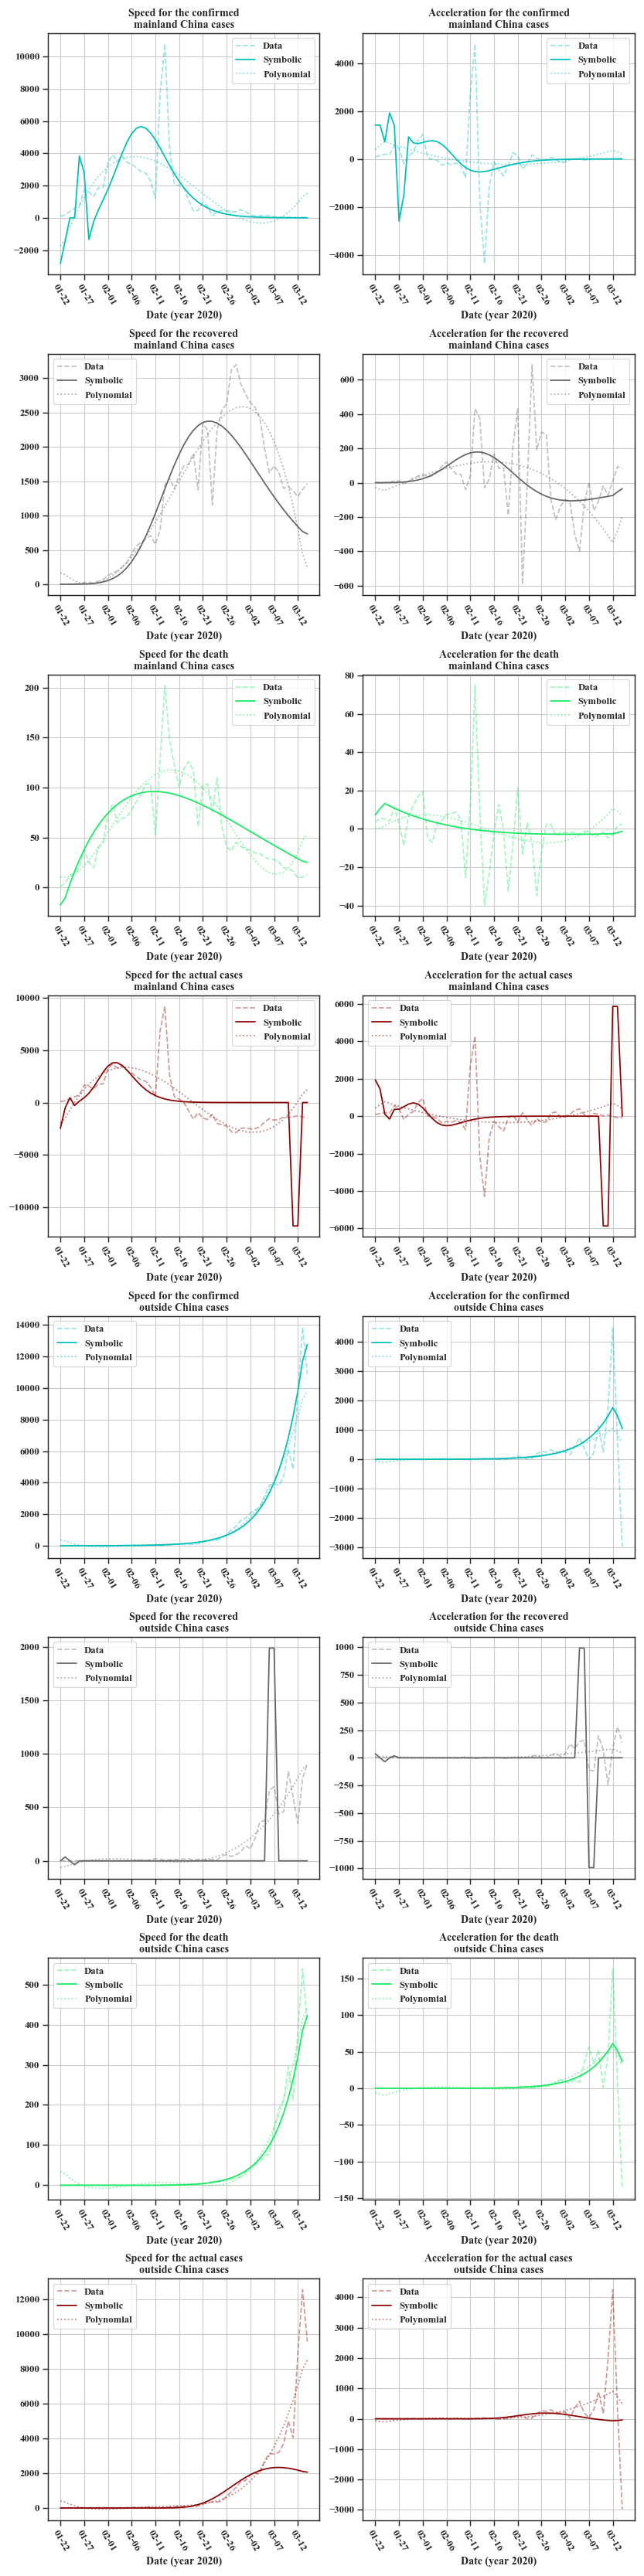

In [94]:
# Each data with the corresponding regression and error
plt.figure(figsize=(10,40))

for i in range(len(cases_words)):
    for place in location:
        
        # Conditions for plots
        if place == location[0]: a = 0
        else: a = 8
        
        # SPEED
        plt.subplot(8,2,2*i+1+a)
        # Data
        plt.plot(x_data, speed_data_values[f'{cases_words[i]}_{place}_china'], 
                    color = colors[i], alpha=.4,linestyle = '--', label = 'Data')
        # Symbolic regression
        plt.plot(x_data, speed_symb_reg_values[f"{cases_words[i]}_{place}_symb_reg"], 
                 color = colors[i], alpha = 1, linestyle = '-', label = 'Symbolic')
        # Polynomial regression
        plt.plot(x_data, speed_poly_reg_values[f"{cases_words[i]}_{place}_poly_reg"], 
                 color = colors[i], alpha = .5, linestyle = ':', label = 'Polynomial')
        
        plt.title(f'Speed for the {cases_words[i].replace("_"," ")}\n{place} China cases')
        plt.xticks(day_pos,day_text,rotation=-60)
        plt.xlabel('Date (year 2020)')
        plt.legend()
        plt.grid()
        
        
        # ACCELERATION
        plt.subplot(8,2,2*i+2+a)
        # Data
        plt.plot(x_data, accel_data_values[f'{cases_words[i]}_{place}_china'], 
                    color = colors[i], alpha=.4,linestyle = '--', label = 'Data')
        # Symbolic regression
        plt.plot(x_data, accel_symb_reg_values[f"{cases_words[i]}_{place}_symb_reg"], 
                 color = colors[i], alpha = 1, linestyle = '-', label = 'Symbolic')
        # Polynomial regression
        plt.plot(x_data, accel_poly_reg_values[f"{cases_words[i]}_{place}_poly_reg"], 
                 color = colors[i], alpha = .5, linestyle = ':', label = 'Polynomial')
        
        plt.title(f'Acceleration for the {cases_words[i].replace("_"," ")}\n{place} China cases')
        plt.xticks(day_pos,day_text,rotation=-60)
        plt.xlabel('Date (year 2020)')
        plt.legend()
        plt.grid()
        

plt.tight_layout()

In [ ]:
# Predictions

In [ ]:
# Proportions of death cases and confirmed cases

In [ ]:
# MAP of the actual cases trough time

In [ ]:
# Determine the death  and recovered percentage functions
death_percentage = 100*regressions['death']['y_symb_scaled']/regressions['confirmed']['y_symb_scaled']
recovered_percentage = 100*regressions['recovered']['y_symb_scaled']/regressions['confirmed']['y_symb_scaled']

plt.figure(figsize=(8,5))

# Real data
plt.subplot(121)

plt.plot(cases_dataframe['numerical_value'], cases_dataframe['death_percentage_mainland_china'],
         color = 'black', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')
plt.plot(cases_dataframe['numerical_value'], cases_dataframe['recovered_percentage_mainland_china'],
         color = 'green', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

#plt.xticks([5*i for i in range(5+1)], [enddate[5*i] for i in range(5+1)], rotation=-60)
plt.xlim(0,25)
plt.ylim(0,15)
plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage\n Cases (Real data)')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')


# Predicted data
plt.subplot(122)

plt.plot(x_vals, death_percentage, color ='black',label = 'Death Percentage')
plt.plot(x_vals, recovered_percentage, color = 'green', label = 'Recovered Percentage')

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.xlim(0,25)
plt.ylim(0,15)
plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage\n Cases (Predicted data)')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')

plt.tight_layout()

In [ ]:
plt.figure(figsize = (8,8))

plt.subplot(221)

plt.plot(x_real_vals, cases_dataframe['death_percentage_mainland_china'],
         color = 'black', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')

y_death_predictions = 100*(prediction_values['death']/prediction_values['confirmed'])

plt.scatter(x_real_vals, y_death_predictions, color = 'blue',alpha=.3)

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title(' Death Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')
plt.grid()


plt.subplot(222)

plt.plot(x_real_vals, cases_dataframe['recovered_percentage_mainland_china'],
         color = 'green', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

y_recovered_predictions = 100*(prediction_values['recovered']/prediction_values['confirmed'])

plt.scatter(x_real_vals, y_recovered_predictions, color = 'blue',alpha=.3)

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Recovery Percentage  Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')
plt.grid()
plt.tight_layout()



plt.subplot(223)
squared_error_death = (cases_dataframe['death_percentage_mainland_china']-y_death_predictions)**2
plt.plot(x_real_vals, squared_error_death,
         color = 'orange', marker='o',alpha=.3, linewidth=1, label = 'Death Percentage')
plt.plot(x_real_vals, np.mean(squared_error_death)*np.ones(len(x_real_vals)),c='r')


day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Square Error from the Death Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Square Error of the Percentage')
plt.grid()


plt.subplot(224)
squared_error_recovered = (cases_dataframe['recovered_percentage_mainland_china']-y_recovered_predictions)**2
plt.plot(x_real_vals, squared_error_recovered ,
         color = 'orange', marker= 'o',alpha=.3,linewidth=1, label = 'Recovered Percentage')

plt.plot(x_real_vals, np.mean(squared_error_recovered)*np.ones(len(x_real_vals)),c='r')

day_spam = 4
#plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.title('Square Error from the Recovery Percentage  Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Square Error of the Percentage')
plt.grid()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(x_vals, death_percentage, color ='black',label = 'Death Percentage')
plt.plot(x_vals[10:], recovered_percentage[10:], color = 'green', label = 'Recovered Percentage')

day_spam = 5
plt.xticks([day_spam*i for i in range(len(enddate)//day_spam+1)], [enddate[day_spam*i] for i in range(len(enddate)//day_spam+1)], rotation=-60)

plt.ylim(0,np.max([np.max(death_percentage),np.max(recovered_percentage)]))
plt.xlim(0,days)

plt.grid()
plt.legend()

plt.title('Death and Recovery Percentage Cases')
plt.xlabel('Date (year 2020)')
plt.ylabel('Percentage (%)')

plt.tight_layout()